# Convolutional Neural Networks (CNN) with PyTorch

This part of the assignment is about implementing a Convolutional Neural Network (CNN) using PyTorch. We will be using a dataset of images of pokemon and predicting their type. 

The dataset will be found in the `data` folder.

# Imports

In [389]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import glob
import cv2
import os

from torchsummary import summary
from tqdm.notebook import tqdm

# pip install -g pandas numpy matplotlib torchvision torch.utils cv2 torchsummary tqdm


# Loading the dataset

We will only be predicting Water, Grass of Fire type pokemon. 

In [390]:
df = pd.read_csv("data/pokemon.csv")
filtered_df = df[df.Type1.isin(["Water", "Grass", "Fire"])][["Name", "Type1"]]

filtered_df = filtered_df.rename(columns=str.lower)


print("Number of Unique Pokemon: ", len(filtered_df.name.unique()))

filtered_df['label'] = filtered_df['type1'].astype('category').cat.codes
filtered_df


Number of Unique Pokemon:  245


,name,type1,label
0,bulbasaur,Grass,1
1,ivysaur,Grass,1
2,venusaur,Grass,1
3,charmander,Fire,0
4,charmeleon,Fire,0
...,...,...,...
778,bruxish,Water,2
786,tapu-bulu,Grass,1
787,tapu-fini,Water,2
797,kartana,Grass,1


# Creating dataset class

In this section we will create a dataset class, and data loaders for the training and test sets.
For this section it would help to have a look at the PyTorch documentation for the `Dataset` and `DataLoader` classes.
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

You are required to complete the implementation for the `PokemonDataset` class.

In [391]:
class PokemonDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        
        # ============ YOUR CODE HERE ============
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
        # ========================================

        

    def __len__(self):
        # ============ YOUR CODE HERE ============
        length_of_dataframe = len(self.dataframe)
        return length_of_dataframe
        # ========================================

    def __getitem__(self, idx):
        # ============ YOUR CODE HERE ============
        img_base = self.dataframe.iloc[idx, 0]
        img_path_png = os.path.join(self.root_dir, 'images', img_base + '.png')
        img_path_jpg = os.path.join(self.root_dir, 'images', img_base + '.jpg')
        

        # Checking both extensions
        image = cv2.imread(img_path_png)
        if image is None:
            image = cv2.imread(img_path_jpg)
        
        
        # Getting the Last Label
        label = self.dataframe.iloc[idx, -1]  
        
        # Getting the Label Name
        label_name = self.dataframe.iloc[idx, 1]  
        
        
        if self.transform:
            image = self.transform(image)
        
        # ========================================
        
        return image, label, label_name


Visualize some of the images present in the dataset, along with their labels.

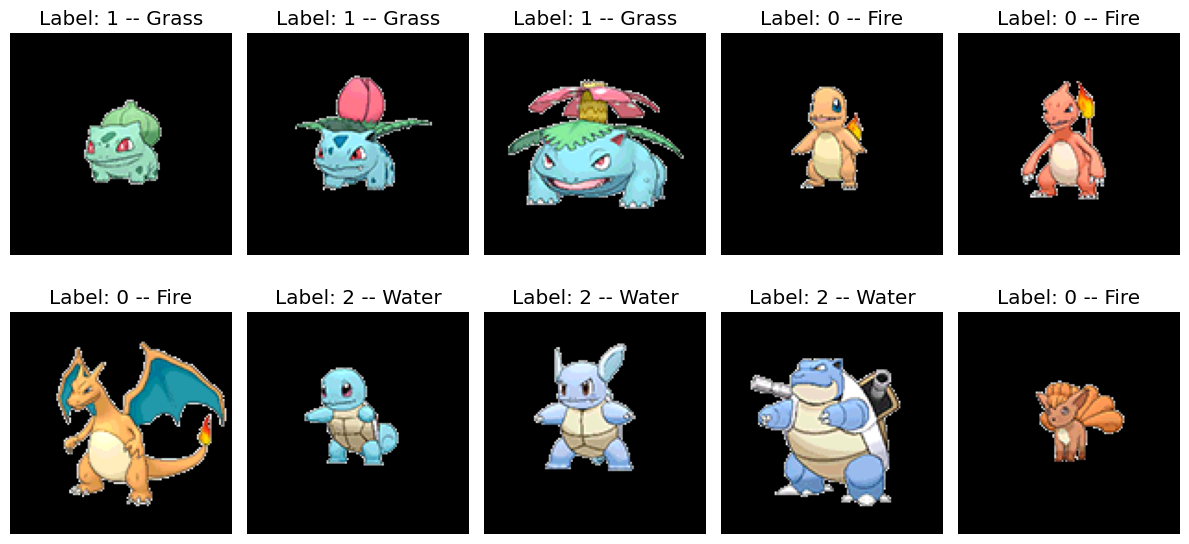

In [392]:
# Create dataset object
dataset = PokemonDataset(filtered_df, root_dir="data")

# Create subplots
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

# Plot images and labels
for i, ax in enumerate(axes.flat):
    image, label, label_name = dataset[i]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax.imshow(image)
    ax.set_title(f"Label: {label} -- {label_name}")
    ax.axis("off")

plt.tight_layout()
plt.show()

Create a train-test split and dataloaders for training data and testing data

In [393]:
from sklearn.model_selection import train_test_split
BATCH_SIZE = 32

# ============ YOUR CODE HERE ==================
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = PokemonDataset(filtered_df, root_dir='data', transform=transform)


train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [394]:
# Check train_dataloader
for images, labels, _ in train_dataloader:
    print("Train Batch:")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    break

# Check test_dataloader
for images, labels, _ in test_dataloader:
    print("Test Batch:")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    break


Train Batch:
Images shape: torch.Size([32, 3, 64, 64])
Labels shape: torch.Size([32])
Test Batch:
Images shape: torch.Size([32, 3, 64, 64])
Labels shape: torch.Size([32])


[ WARN:0@8859.819] global loadsave.cpp:248 findDecoder imread_('data/images/wishiwashi-solo.png'): can't open/read file: check file path/integrity
[ WARN:0@8859.830] global loadsave.cpp:248 findDecoder imread_('data/images/shiinotic.png'): can't open/read file: check file path/integrity
[ WARN:0@8859.835] global loadsave.cpp:248 findDecoder imread_('data/images/torracat.png'): can't open/read file: check file path/integrity


# Designing CNN Architecture
In this section we will create a model class, which contains the different layers for your CNN.
For this section it would help to have a look at the PyTorch tutorial and documentation for creating a model.
https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html

You are required to complete the implementation for the `PokemonModel` class.

In [395]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class PokemonModel(nn.Module):
    def __init__(self,num_classes=3):
        super(PokemonModel, self).__init__()
        # ================= Your Code Here ===============
        
        # CNN Layers
        3=> 32 => 64 => 
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        
        # Pooling 
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # FCN
        self.fc1 = nn.Linear(128 * 8 * 8, out_features=512)  # Adjust input size based on the output of the last conv layer
        self.fc2 = nn.Linear(in_features=512, out_features=3)

        # =================================================

        
    def forward(self, x):
        # ================= Your Code Here ===============
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
      
      
        # Flatten
        x = x.view(-1, 128 * 8 * 8)
        
        # 1st Hidden Layer, with Relu 
        x = torch.relu(self.fc1(x))
        
        # 2nd hidden layerr == > Output Layer
        x = self.fc2(x)
        # ================================================
    
        return x
        


# Train your CNN
In this section, you are required to train your CNN on the Pokemon Dataset. You may change the `criterion`, `optimizer`, `lr` and `NUM_EPOCHS`.
You have to implement the model training for each epoch.

In [396]:
model = PokemonModel()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

summary(model, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
         MaxPool2d-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          18,496
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
         MaxPool2d-6            [-1, 128, 8, 8]               0
            Linear-7                  [-1, 512]       4,194,816
            Linear-8                    [-1, 3]           1,539
Total params: 4,289,603
Trainable params: 4,289,603
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 2.19
Params size (MB): 16.36
Estimated Total Size (MB): 18.60
----------------------------------------------------------------


In [397]:
# Set the model to training mode
model.train()
NUM_EPOCHS = 30

loss_list = []
accuracy_list = []
# Training loop
for epoch in tqdm(range(NUM_EPOCHS)):
    # ============ YOUR CODE HERE ============
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for i, data in enumerate(train_dataloader, 0):
        inputs, labels, _ = data

        # Convert inputs and labels to the correct device (GPU or CPU)
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Convert labels to long type
        labels = labels.long()  # Ensure labels are of type torch.long

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass: Compute predicted y by passing x to the model
        outputs = model(inputs)

        # Compute and print loss
        loss = criterion(outputs, labels)
        loss.backward()  # Backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step()  # Update model parameters

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataloader)
    epoch_accuracy = correct_predictions / total_predictions

    loss_list.append(epoch_loss)
    accuracy_list.append(epoch_accuracy)

    print(f'Epoch {epoch + 1}, Loss: {epoch_loss}, Accuracy: {epoch_accuracy}')
    # ========================================
print('Finished Training')


  0%|          | 0/30 [00:00<?, ?it/s]

[ WARN:0@8859.900] global loadsave.cpp:248 findDecoder imread_('data/images/blacephalon.png'): can't open/read file: check file path/integrity
[ WARN:0@8859.904] global loadsave.cpp:248 findDecoder imread_('data/images/morelull.png'): can't open/read file: check file path/integrity
[ WARN:0@8859.906] global loadsave.cpp:248 findDecoder imread_('data/images/rowlet.png'): can't open/read file: check file path/integrity
[ WARN:0@8859.909] global loadsave.cpp:248 findDecoder imread_('data/images/dartrix.png'): can't open/read file: check file path/integrity
[ WARN:0@8860.089] global loadsave.cpp:248 findDecoder imread_('data/images/steenee.png'): can't open/read file: check file path/integrity
[ WARN:0@8860.092] global loadsave.cpp:248 findDecoder imread_('data/images/tapu-fini.png'): can't open/read file: check file path/integrity
[ WARN:0@8860.100] global loadsave.cpp:248 findDecoder imread_('data/images/incineroar.png'): can't open/read file: check file path/integrity
[ WARN:0@8860.101]

Epoch 1, Loss: 1.2016831125531877, Accuracy: 0.336734693877551


[ WARN:0@8860.827] global loadsave.cpp:248 findDecoder imread_('data/images/dewpider.png'): can't open/read file: check file path/integrity
[ WARN:0@8860.829] global loadsave.cpp:248 findDecoder imread_('data/images/wishiwashi-solo.png'): can't open/read file: check file path/integrity
[ WARN:0@8860.830] global loadsave.cpp:248 findDecoder imread_('data/images/bounsweet.png'): can't open/read file: check file path/integrity
[ WARN:0@8860.832] global loadsave.cpp:248 findDecoder imread_('data/images/incineroar.png'): can't open/read file: check file path/integrity
[ WARN:0@8860.833] global loadsave.cpp:248 findDecoder imread_('data/images/kartana.png'): can't open/read file: check file path/integrity
[ WARN:0@8860.932] global loadsave.cpp:248 findDecoder imread_('data/images/tapu-fini.png'): can't open/read file: check file path/integrity
[ WARN:0@8860.933] global loadsave.cpp:248 findDecoder imread_('data/images/tapu-bulu.png'): can't open/read file: check file path/integrity
[ WARN:0@

Epoch 2, Loss: 0.9981086339269366, Accuracy: 0.5816326530612245


[ WARN:0@8861.461] global loadsave.cpp:248 findDecoder imread_('data/images/litten.png'): can't open/read file: check file path/integrity
[ WARN:0@8861.462] global loadsave.cpp:248 findDecoder imread_('data/images/tapu-fini.png'): can't open/read file: check file path/integrity
[ WARN:0@8861.466] global loadsave.cpp:248 findDecoder imread_('data/images/pyukumuku.png'): can't open/read file: check file path/integrity
[ WARN:0@8861.471] global loadsave.cpp:248 findDecoder imread_('data/images/rowlet.png'): can't open/read file: check file path/integrity
[ WARN:0@8861.567] global loadsave.cpp:248 findDecoder imread_('data/images/decidueye.png'): can't open/read file: check file path/integrity
[ WARN:0@8861.570] global loadsave.cpp:248 findDecoder imread_('data/images/morelull.png'): can't open/read file: check file path/integrity
[ WARN:0@8861.571] global loadsave.cpp:248 findDecoder imread_('data/images/araquanid.png'): can't open/read file: check file path/integrity
[ WARN:0@8861.573] g

Epoch 3, Loss: 0.882519108908517, Accuracy: 0.5612244897959183


[ WARN:0@8862.160] global loadsave.cpp:248 findDecoder imread_('data/images/popplio.png'): can't open/read file: check file path/integrity
[ WARN:0@8862.169] global loadsave.cpp:248 findDecoder imread_('data/images/pyukumuku.png'): can't open/read file: check file path/integrity
[ WARN:0@8862.171] global loadsave.cpp:248 findDecoder imread_('data/images/litten.png'): can't open/read file: check file path/integrity
[ WARN:0@8862.273] global loadsave.cpp:248 findDecoder imread_('data/images/bruxish.png'): can't open/read file: check file path/integrity
[ WARN:0@8862.276] global loadsave.cpp:248 findDecoder imread_('data/images/dartrix.png'): can't open/read file: check file path/integrity
[ WARN:0@8862.279] global loadsave.cpp:248 findDecoder imread_('data/images/morelull.png'): can't open/read file: check file path/integrity
[ WARN:0@8862.280] global loadsave.cpp:248 findDecoder imread_('data/images/primarina.png'): can't open/read file: check file path/integrity
[ WARN:0@8862.387] glob

Epoch 4, Loss: 0.8184477431433541, Accuracy: 0.6122448979591837


[ WARN:0@8862.870] global loadsave.cpp:248 findDecoder imread_('data/images/wishiwashi-solo.png'): can't open/read file: check file path/integrity
[ WARN:0@8862.873] global loadsave.cpp:248 findDecoder imread_('data/images/dartrix.png'): can't open/read file: check file path/integrity
[ WARN:0@8863.053] global loadsave.cpp:248 findDecoder imread_('data/images/turtonator.png'): can't open/read file: check file path/integrity
[ WARN:0@8863.062] global loadsave.cpp:248 findDecoder imread_('data/images/steenee.png'): can't open/read file: check file path/integrity
[ WARN:0@8863.203] global loadsave.cpp:248 findDecoder imread_('data/images/incineroar.png'): can't open/read file: check file path/integrity
[ WARN:0@8863.205] global loadsave.cpp:248 findDecoder imread_('data/images/litten.png'): can't open/read file: check file path/integrity
[ WARN:0@8863.206] global loadsave.cpp:248 findDecoder imread_('data/images/pyukumuku.png'): can't open/read file: check file path/integrity
[ WARN:0@886

Epoch 5, Loss: 0.7247906497546605, Accuracy: 0.6479591836734694


[ WARN:0@8863.646] global loadsave.cpp:248 findDecoder imread_('data/images/kartana.png'): can't open/read file: check file path/integrity
[ WARN:0@8863.649] global loadsave.cpp:248 findDecoder imread_('data/images/morelull.png'): can't open/read file: check file path/integrity
[ WARN:0@8863.653] global loadsave.cpp:248 findDecoder imread_('data/images/blacephalon.png'): can't open/read file: check file path/integrity
[ WARN:0@8863.749] global loadsave.cpp:248 findDecoder imread_('data/images/araquanid.png'): can't open/read file: check file path/integrity
[ WARN:0@8863.751] global loadsave.cpp:248 findDecoder imread_('data/images/litten.png'): can't open/read file: check file path/integrity
[ WARN:0@8863.752] global loadsave.cpp:248 findDecoder imread_('data/images/pyukumuku.png'): can't open/read file: check file path/integrity
[ WARN:0@8863.753] global loadsave.cpp:248 findDecoder imread_('data/images/bounsweet.png'): can't open/read file: check file path/integrity
[ WARN:0@8863.754

Epoch 6, Loss: 0.7777145419801984, Accuracy: 0.7142857142857143


[ WARN:0@8864.340] global loadsave.cpp:248 findDecoder imread_('data/images/brionne.png'): can't open/read file: check file path/integrity
[ WARN:0@8864.342] global loadsave.cpp:248 findDecoder imread_('data/images/wishiwashi-solo.png'): can't open/read file: check file path/integrity
[ WARN:0@8864.344] global loadsave.cpp:248 findDecoder imread_('data/images/fomantis.png'): can't open/read file: check file path/integrity
[ WARN:0@8864.346] global loadsave.cpp:248 findDecoder imread_('data/images/bounsweet.png'): can't open/read file: check file path/integrity
[ WARN:0@8864.346] global loadsave.cpp:248 findDecoder imread_('data/images/kartana.png'): can't open/read file: check file path/integrity
[ WARN:0@8864.443] global loadsave.cpp:248 findDecoder imread_('data/images/blacephalon.png'): can't open/read file: check file path/integrity
[ WARN:0@8864.444] global loadsave.cpp:248 findDecoder imread_('data/images/araquanid.png'): can't open/read file: check file path/integrity
[ WARN:0@8

Epoch 7, Loss: 0.6916240709168571, Accuracy: 0.6785714285714286


[ WARN:0@8864.988] global loadsave.cpp:248 findDecoder imread_('data/images/blacephalon.png'): can't open/read file: check file path/integrity
[ WARN:0@8864.993] global loadsave.cpp:248 findDecoder imread_('data/images/kartana.png'): can't open/read file: check file path/integrity
[ WARN:0@8864.994] global loadsave.cpp:248 findDecoder imread_('data/images/fomantis.png'): can't open/read file: check file path/integrity
[ WARN:0@8864.995] global loadsave.cpp:248 findDecoder imread_('data/images/wishiwashi-solo.png'): can't open/read file: check file path/integrity
[ WARN:0@8864.995] global loadsave.cpp:248 findDecoder imread_('data/images/oricorio-baile.png'): can't open/read file: check file path/integrity
[ WARN:0@8864.996] global loadsave.cpp:248 findDecoder imread_('data/images/lurantis.png'): can't open/read file: check file path/integrity
[ WARN:0@8865.091] global loadsave.cpp:248 findDecoder imread_('data/images/tsareena.png'): can't open/read file: check file path/integrity
[ WAR

Epoch 8, Loss: 0.5839503748076302, Accuracy: 0.7244897959183674


[ WARN:0@8865.629] global loadsave.cpp:248 findDecoder imread_('data/images/lurantis.png'): can't open/read file: check file path/integrity
[ WARN:0@8865.631] global loadsave.cpp:248 findDecoder imread_('data/images/tapu-bulu.png'): can't open/read file: check file path/integrity
[ WARN:0@8865.632] global loadsave.cpp:248 findDecoder imread_('data/images/pyukumuku.png'): can't open/read file: check file path/integrity
[ WARN:0@8865.733] global loadsave.cpp:248 findDecoder imread_('data/images/popplio.png'): can't open/read file: check file path/integrity
[ WARN:0@8865.739] global loadsave.cpp:248 findDecoder imread_('data/images/wishiwashi-solo.png'): can't open/read file: check file path/integrity
[ WARN:0@8865.836] global loadsave.cpp:248 findDecoder imread_('data/images/primarina.png'): can't open/read file: check file path/integrity
[ WARN:0@8865.837] global loadsave.cpp:248 findDecoder imread_('data/images/blacephalon.png'): can't open/read file: check file path/integrity
[ WARN:0

Epoch 9, Loss: 0.5052062209163394, Accuracy: 0.7653061224489796


[ WARN:0@8866.256] global loadsave.cpp:248 findDecoder imread_('data/images/incineroar.png'): can't open/read file: check file path/integrity
[ WARN:0@8866.258] global loadsave.cpp:248 findDecoder imread_('data/images/decidueye.png'): can't open/read file: check file path/integrity
[ WARN:0@8866.259] global loadsave.cpp:248 findDecoder imread_('data/images/dartrix.png'): can't open/read file: check file path/integrity
[ WARN:0@8866.263] global loadsave.cpp:248 findDecoder imread_('data/images/lurantis.png'): can't open/read file: check file path/integrity
[ WARN:0@8866.361] global loadsave.cpp:248 findDecoder imread_('data/images/steenee.png'): can't open/read file: check file path/integrity
[ WARN:0@8866.363] global loadsave.cpp:248 findDecoder imread_('data/images/popplio.png'): can't open/read file: check file path/integrity
[ WARN:0@8866.364] global loadsave.cpp:248 findDecoder imread_('data/images/primarina.png'): can't open/read file: check file path/integrity
[ WARN:0@8866.364] 

Epoch 10, Loss: 0.4776961164815085, Accuracy: 0.8112244897959183


[ WARN:0@8866.929] global loadsave.cpp:248 findDecoder imread_('data/images/primarina.png'): can't open/read file: check file path/integrity
[ WARN:0@8866.932] global loadsave.cpp:248 findDecoder imread_('data/images/tsareena.png'): can't open/read file: check file path/integrity
[ WARN:0@8866.932] global loadsave.cpp:248 findDecoder imread_('data/images/fomantis.png'): can't open/read file: check file path/integrity
[ WARN:0@8867.025] global loadsave.cpp:248 findDecoder imread_('data/images/incineroar.png'): can't open/read file: check file path/integrity
[ WARN:0@8867.025] global loadsave.cpp:248 findDecoder imread_('data/images/turtonator.png'): can't open/read file: check file path/integrity
[ WARN:0@8867.028] global loadsave.cpp:248 findDecoder imread_('data/images/tapu-fini.png'): can't open/read file: check file path/integrity
[ WARN:0@8867.029] global loadsave.cpp:248 findDecoder imread_('data/images/morelull.png'): can't open/read file: check file path/integrity
[ WARN:0@8867.

Epoch 11, Loss: 0.42072899852480206, Accuracy: 0.8214285714285714


[ WARN:0@8867.581] global loadsave.cpp:248 findDecoder imread_('data/images/rowlet.png'): can't open/read file: check file path/integrity
[ WARN:0@8867.586] global loadsave.cpp:248 findDecoder imread_('data/images/decidueye.png'): can't open/read file: check file path/integrity
[ WARN:0@8867.586] global loadsave.cpp:248 findDecoder imread_('data/images/morelull.png'): can't open/read file: check file path/integrity
[ WARN:0@8867.587] global loadsave.cpp:248 findDecoder imread_('data/images/bruxish.png'): can't open/read file: check file path/integrity
[ WARN:0@8867.588] global loadsave.cpp:248 findDecoder imread_('data/images/brionne.png'): can't open/read file: check file path/integrity
[ WARN:0@8867.589] global loadsave.cpp:248 findDecoder imread_('data/images/blacephalon.png'): can't open/read file: check file path/integrity
[ WARN:0@8867.693] global loadsave.cpp:248 findDecoder imread_('data/images/popplio.png'): can't open/read file: check file path/integrity
[ WARN:0@8867.694] gl

Epoch 12, Loss: 0.3606494643858501, Accuracy: 0.8826530612244898


[ WARN:0@8868.241] global loadsave.cpp:248 findDecoder imread_('data/images/decidueye.png'): can't open/read file: check file path/integrity
[ WARN:0@8868.244] global loadsave.cpp:248 findDecoder imread_('data/images/tsareena.png'): can't open/read file: check file path/integrity
[ WARN:0@8868.245] global loadsave.cpp:248 findDecoder imread_('data/images/turtonator.png'): can't open/read file: check file path/integrity
[ WARN:0@8868.345] global loadsave.cpp:248 findDecoder imread_('data/images/dartrix.png'): can't open/read file: check file path/integrity
[ WARN:0@8868.350] global loadsave.cpp:248 findDecoder imread_('data/images/bounsweet.png'): can't open/read file: check file path/integrity
[ WARN:0@8868.350] global loadsave.cpp:248 findDecoder imread_('data/images/araquanid.png'): can't open/read file: check file path/integrity
[ WARN:0@8868.351] global loadsave.cpp:248 findDecoder imread_('data/images/oricorio-baile.png'): can't open/read file: check file path/integrity
[ WARN:0@8

Epoch 13, Loss: 0.26082521251269747, Accuracy: 0.8724489795918368


[ WARN:0@8868.900] global loadsave.cpp:248 findDecoder imread_('data/images/decidueye.png'): can't open/read file: check file path/integrity
[ WARN:0@8868.901] global loadsave.cpp:248 findDecoder imread_('data/images/dewpider.png'): can't open/read file: check file path/integrity
[ WARN:0@8868.901] global loadsave.cpp:248 findDecoder imread_('data/images/tapu-bulu.png'): can't open/read file: check file path/integrity
[ WARN:0@8868.902] global loadsave.cpp:248 findDecoder imread_('data/images/tapu-fini.png'): can't open/read file: check file path/integrity
[ WARN:0@8868.903] global loadsave.cpp:248 findDecoder imread_('data/images/fomantis.png'): can't open/read file: check file path/integrity
[ WARN:0@8868.906] global loadsave.cpp:248 findDecoder imread_('data/images/araquanid.png'): can't open/read file: check file path/integrity
[ WARN:0@8868.906] global loadsave.cpp:248 findDecoder imread_('data/images/brionne.png'): can't open/read file: check file path/integrity
[ WARN:0@8868.906

Epoch 14, Loss: 0.22017484796898706, Accuracy: 0.9030612244897959


[ WARN:0@8869.552] global loadsave.cpp:248 findDecoder imread_('data/images/bruxish.png'): can't open/read file: check file path/integrity
[ WARN:0@8869.554] global loadsave.cpp:248 findDecoder imread_('data/images/wishiwashi-solo.png'): can't open/read file: check file path/integrity
[ WARN:0@8869.556] global loadsave.cpp:248 findDecoder imread_('data/images/dartrix.png'): can't open/read file: check file path/integrity
[ WARN:0@8869.557] global loadsave.cpp:248 findDecoder imread_('data/images/pyukumuku.png'): can't open/read file: check file path/integrity
[ WARN:0@8869.647] global loadsave.cpp:248 findDecoder imread_('data/images/litten.png'): can't open/read file: check file path/integrity
[ WARN:0@8869.650] global loadsave.cpp:248 findDecoder imread_('data/images/bounsweet.png'): can't open/read file: check file path/integrity
[ WARN:0@8869.652] global loadsave.cpp:248 findDecoder imread_('data/images/turtonator.png'): can't open/read file: check file path/integrity
[ WARN:0@8869

Epoch 15, Loss: 0.15411817521921226, Accuracy: 0.9336734693877551


[ WARN:0@8870.304] global loadsave.cpp:248 findDecoder imread_('data/images/incineroar.png'): can't open/read file: check file path/integrity
[ WARN:0@8870.311] global loadsave.cpp:248 findDecoder imread_('data/images/bruxish.png'): can't open/read file: check file path/integrity
[ WARN:0@8870.314] global loadsave.cpp:248 findDecoder imread_('data/images/popplio.png'): can't open/read file: check file path/integrity
[ WARN:0@8870.421] global loadsave.cpp:248 findDecoder imread_('data/images/pyukumuku.png'): can't open/read file: check file path/integrity
[ WARN:0@8870.425] global loadsave.cpp:248 findDecoder imread_('data/images/dewpider.png'): can't open/read file: check file path/integrity
[ WARN:0@8870.426] global loadsave.cpp:248 findDecoder imread_('data/images/primarina.png'): can't open/read file: check file path/integrity
[ WARN:0@8870.426] global loadsave.cpp:248 findDecoder imread_('data/images/oricorio-baile.png'): can't open/read file: check file path/integrity
[ WARN:0@887

Epoch 16, Loss: 0.13563513436487742, Accuracy: 0.9438775510204082


[ WARN:0@8870.993] global loadsave.cpp:248 findDecoder imread_('data/images/steenee.png'): can't open/read file: check file path/integrity
[ WARN:0@8871.000] global loadsave.cpp:248 findDecoder imread_('data/images/primarina.png'): can't open/read file: check file path/integrity
[ WARN:0@8871.003] global loadsave.cpp:248 findDecoder imread_('data/images/bounsweet.png'): can't open/read file: check file path/integrity
[ WARN:0@8871.099] global loadsave.cpp:248 findDecoder imread_('data/images/litten.png'): can't open/read file: check file path/integrity
[ WARN:0@8871.101] global loadsave.cpp:248 findDecoder imread_('data/images/bruxish.png'): can't open/read file: check file path/integrity
[ WARN:0@8871.105] global loadsave.cpp:248 findDecoder imread_('data/images/decidueye.png'): can't open/read file: check file path/integrity
[ WARN:0@8871.225] global loadsave.cpp:248 findDecoder imread_('data/images/lurantis.png'): can't open/read file: check file path/integrity
[ WARN:0@8871.229] gl

Epoch 17, Loss: 0.14139358965413912, Accuracy: 0.9744897959183674


[ WARN:0@8871.734] global loadsave.cpp:248 findDecoder imread_('data/images/tapu-bulu.png'): can't open/read file: check file path/integrity
[ WARN:0@8871.739] global loadsave.cpp:248 findDecoder imread_('data/images/wishiwashi-solo.png'): can't open/read file: check file path/integrity
[ WARN:0@8871.742] global loadsave.cpp:248 findDecoder imread_('data/images/steenee.png'): can't open/read file: check file path/integrity
[ WARN:0@8871.840] global loadsave.cpp:248 findDecoder imread_('data/images/litten.png'): can't open/read file: check file path/integrity
[ WARN:0@8871.843] global loadsave.cpp:248 findDecoder imread_('data/images/kartana.png'): can't open/read file: check file path/integrity
[ WARN:0@8871.844] global loadsave.cpp:248 findDecoder imread_('data/images/primarina.png'): can't open/read file: check file path/integrity
[ WARN:0@8871.846] global loadsave.cpp:248 findDecoder imread_('data/images/araquanid.png'): can't open/read file: check file path/integrity
[ WARN:0@8871.

Epoch 18, Loss: 0.21775427354233606, Accuracy: 0.923469387755102


[ WARN:0@8872.422] global loadsave.cpp:248 findDecoder imread_('data/images/litten.png'): can't open/read file: check file path/integrity
[ WARN:0@8872.424] global loadsave.cpp:248 findDecoder imread_('data/images/decidueye.png'): can't open/read file: check file path/integrity
[ WARN:0@8872.425] global loadsave.cpp:248 findDecoder imread_('data/images/bounsweet.png'): can't open/read file: check file path/integrity
[ WARN:0@8872.426] global loadsave.cpp:248 findDecoder imread_('data/images/primarina.png'): can't open/read file: check file path/integrity
[ WARN:0@8872.529] global loadsave.cpp:248 findDecoder imread_('data/images/tapu-bulu.png'): can't open/read file: check file path/integrity
[ WARN:0@8872.530] global loadsave.cpp:248 findDecoder imread_('data/images/wishiwashi-solo.png'): can't open/read file: check file path/integrity
[ WARN:0@8872.533] global loadsave.cpp:248 findDecoder imread_('data/images/araquanid.png'): can't open/read file: check file path/integrity
[ WARN:0@8

Epoch 19, Loss: 0.11310971641380872, Accuracy: 0.9489795918367347


[ WARN:0@8873.094] global loadsave.cpp:248 findDecoder imread_('data/images/tsareena.png'): can't open/read file: check file path/integrity
[ WARN:0@8873.104] global loadsave.cpp:248 findDecoder imread_('data/images/dartrix.png'): can't open/read file: check file path/integrity
[ WARN:0@8873.196] global loadsave.cpp:248 findDecoder imread_('data/images/pyukumuku.png'): can't open/read file: check file path/integrity
[ WARN:0@8873.198] global loadsave.cpp:248 findDecoder imread_('data/images/incineroar.png'): can't open/read file: check file path/integrity
[ WARN:0@8873.203] global loadsave.cpp:248 findDecoder imread_('data/images/turtonator.png'): can't open/read file: check file path/integrity
[ WARN:0@8873.302] global loadsave.cpp:248 findDecoder imread_('data/images/tapu-bulu.png'): can't open/read file: check file path/integrity
[ WARN:0@8873.303] global loadsave.cpp:248 findDecoder imread_('data/images/popplio.png'): can't open/read file: check file path/integrity
[ WARN:0@8873.30

Epoch 20, Loss: 0.08466183487325907, Accuracy: 0.9948979591836735


[ WARN:0@8873.743] global loadsave.cpp:248 findDecoder imread_('data/images/popplio.png'): can't open/read file: check file path/integrity
[ WARN:0@8873.744] global loadsave.cpp:248 findDecoder imread_('data/images/araquanid.png'): can't open/read file: check file path/integrity
[ WARN:0@8873.746] global loadsave.cpp:248 findDecoder imread_('data/images/decidueye.png'): can't open/read file: check file path/integrity
[ WARN:0@8873.748] global loadsave.cpp:248 findDecoder imread_('data/images/bruxish.png'): can't open/read file: check file path/integrity
[ WARN:0@8873.847] global loadsave.cpp:248 findDecoder imread_('data/images/pyukumuku.png'): can't open/read file: check file path/integrity
[ WARN:0@8873.849] global loadsave.cpp:248 findDecoder imread_('data/images/fomantis.png'): can't open/read file: check file path/integrity
[ WARN:0@8873.850] global loadsave.cpp:248 findDecoder imread_('data/images/lurantis.png'): can't open/read file: check file path/integrity
[ WARN:0@8873.851] 

Epoch 21, Loss: 0.07499337555574519, Accuracy: 0.9744897959183674


[ WARN:0@8874.404] global loadsave.cpp:248 findDecoder imread_('data/images/lurantis.png'): can't open/read file: check file path/integrity
[ WARN:0@8874.404] global loadsave.cpp:248 findDecoder imread_('data/images/wishiwashi-solo.png'): can't open/read file: check file path/integrity
[ WARN:0@8874.407] global loadsave.cpp:248 findDecoder imread_('data/images/decidueye.png'): can't open/read file: check file path/integrity
[ WARN:0@8874.411] global loadsave.cpp:248 findDecoder imread_('data/images/tapu-fini.png'): can't open/read file: check file path/integrity
[ WARN:0@8874.510] global loadsave.cpp:248 findDecoder imread_('data/images/tapu-bulu.png'): can't open/read file: check file path/integrity
[ WARN:0@8874.511] global loadsave.cpp:248 findDecoder imread_('data/images/kartana.png'): can't open/read file: check file path/integrity
[ WARN:0@8874.512] global loadsave.cpp:248 findDecoder imread_('data/images/oricorio-baile.png'): can't open/read file: check file path/integrity
[ WAR

Epoch 22, Loss: 0.05997104237654379, Accuracy: 0.9744897959183674


[ WARN:0@8875.053] global loadsave.cpp:248 findDecoder imread_('data/images/tsareena.png'): can't open/read file: check file path/integrity
[ WARN:0@8875.057] global loadsave.cpp:248 findDecoder imread_('data/images/turtonator.png'): can't open/read file: check file path/integrity
[ WARN:0@8875.061] global loadsave.cpp:248 findDecoder imread_('data/images/wishiwashi-solo.png'): can't open/read file: check file path/integrity
[ WARN:0@8875.158] global loadsave.cpp:248 findDecoder imread_('data/images/decidueye.png'): can't open/read file: check file path/integrity
[ WARN:0@8875.161] global loadsave.cpp:248 findDecoder imread_('data/images/litten.png'): can't open/read file: check file path/integrity
[ WARN:0@8875.162] global loadsave.cpp:248 findDecoder imread_('data/images/rowlet.png'): can't open/read file: check file path/integrity
[ WARN:0@8875.166] global loadsave.cpp:248 findDecoder imread_('data/images/blacephalon.png'): can't open/read file: check file path/integrity
[ WARN:0@88

Epoch 23, Loss: 0.042508416809141636, Accuracy: 0.9948979591836735


[ WARN:0@8875.706] global loadsave.cpp:248 findDecoder imread_('data/images/popplio.png'): can't open/read file: check file path/integrity
[ WARN:0@8875.707] global loadsave.cpp:248 findDecoder imread_('data/images/dewpider.png'): can't open/read file: check file path/integrity
[ WARN:0@8875.709] global loadsave.cpp:248 findDecoder imread_('data/images/oricorio-baile.png'): can't open/read file: check file path/integrity
[ WARN:0@8875.714] global loadsave.cpp:248 findDecoder imread_('data/images/primarina.png'): can't open/read file: check file path/integrity
[ WARN:0@8875.805] global loadsave.cpp:248 findDecoder imread_('data/images/rowlet.png'): can't open/read file: check file path/integrity
[ WARN:0@8875.808] global loadsave.cpp:248 findDecoder imread_('data/images/incineroar.png'): can't open/read file: check file path/integrity
[ WARN:0@8875.811] global loadsave.cpp:248 findDecoder imread_('data/images/wishiwashi-solo.png'): can't open/read file: check file path/integrity
[ WARN:

Epoch 24, Loss: 0.034633896579699855, Accuracy: 0.9948979591836735


[ WARN:0@8876.360] global loadsave.cpp:248 findDecoder imread_('data/images/wishiwashi-solo.png'): can't open/read file: check file path/integrity
[ WARN:0@8876.365] global loadsave.cpp:248 findDecoder imread_('data/images/tapu-bulu.png'): can't open/read file: check file path/integrity
[ WARN:0@8876.367] global loadsave.cpp:248 findDecoder imread_('data/images/bounsweet.png'): can't open/read file: check file path/integrity
[ WARN:0@8876.368] global loadsave.cpp:248 findDecoder imread_('data/images/blacephalon.png'): can't open/read file: check file path/integrity
[ WARN:0@8876.464] global loadsave.cpp:248 findDecoder imread_('data/images/kartana.png'): can't open/read file: check file path/integrity
[ WARN:0@8876.470] global loadsave.cpp:248 findDecoder imread_('data/images/dartrix.png'): can't open/read file: check file path/integrity
[ WARN:0@8876.472] global loadsave.cpp:248 findDecoder imread_('data/images/oricorio-baile.png'): can't open/read file: check file path/integrity
[ WA

Epoch 25, Loss: 0.025966279225290885, Accuracy: 0.9948979591836735


[ WARN:0@8877.008] global loadsave.cpp:248 findDecoder imread_('data/images/kartana.png'): can't open/read file: check file path/integrity
[ WARN:0@8877.013] global loadsave.cpp:248 findDecoder imread_('data/images/fomantis.png'): can't open/read file: check file path/integrity
[ WARN:0@8877.014] global loadsave.cpp:248 findDecoder imread_('data/images/decidueye.png'): can't open/read file: check file path/integrity
[ WARN:0@8877.014] global loadsave.cpp:248 findDecoder imread_('data/images/primarina.png'): can't open/read file: check file path/integrity
[ WARN:0@8877.109] global loadsave.cpp:248 findDecoder imread_('data/images/dewpider.png'): can't open/read file: check file path/integrity
[ WARN:0@8877.110] global loadsave.cpp:248 findDecoder imread_('data/images/bruxish.png'): can't open/read file: check file path/integrity
[ WARN:0@8877.112] global loadsave.cpp:248 findDecoder imread_('data/images/turtonator.png'): can't open/read file: check file path/integrity
[ WARN:0@8877.114]

Epoch 26, Loss: 0.015374157245137863, Accuracy: 1.0


[ WARN:0@8877.678] global loadsave.cpp:248 findDecoder imread_('data/images/popplio.png'): can't open/read file: check file path/integrity
[ WARN:0@8877.679] global loadsave.cpp:248 findDecoder imread_('data/images/morelull.png'): can't open/read file: check file path/integrity
[ WARN:0@8877.681] global loadsave.cpp:248 findDecoder imread_('data/images/araquanid.png'): can't open/read file: check file path/integrity
[ WARN:0@8877.683] global loadsave.cpp:248 findDecoder imread_('data/images/dartrix.png'): can't open/read file: check file path/integrity
[ WARN:0@8877.685] global loadsave.cpp:248 findDecoder imread_('data/images/tsareena.png'): can't open/read file: check file path/integrity
[ WARN:0@8877.786] global loadsave.cpp:248 findDecoder imread_('data/images/decidueye.png'): can't open/read file: check file path/integrity
[ WARN:0@8877.787] global loadsave.cpp:248 findDecoder imread_('data/images/pyukumuku.png'): can't open/read file: check file path/integrity
[ WARN:0@8877.788] 

Epoch 27, Loss: 0.013362123897033078, Accuracy: 0.9948979591836735


[ WARN:0@8878.354] global loadsave.cpp:248 findDecoder imread_('data/images/primarina.png'): can't open/read file: check file path/integrity
[ WARN:0@8878.359] global loadsave.cpp:248 findDecoder imread_('data/images/bruxish.png'): can't open/read file: check file path/integrity
[ WARN:0@8878.460] global loadsave.cpp:248 findDecoder imread_('data/images/pyukumuku.png'): can't open/read file: check file path/integrity
[ WARN:0@8878.461] global loadsave.cpp:248 findDecoder imread_('data/images/araquanid.png'): can't open/read file: check file path/integrity
[ WARN:0@8878.463] global loadsave.cpp:248 findDecoder imread_('data/images/kartana.png'): can't open/read file: check file path/integrity
[ WARN:0@8878.464] global loadsave.cpp:248 findDecoder imread_('data/images/tapu-bulu.png'): can't open/read file: check file path/integrity
[ WARN:0@8878.465] global loadsave.cpp:248 findDecoder imread_('data/images/dewpider.png'): can't open/read file: check file path/integrity
[ WARN:0@8878.567]

Epoch 28, Loss: 0.007101429443407271, Accuracy: 1.0


[ WARN:0@8879.004] global loadsave.cpp:248 findDecoder imread_('data/images/tapu-bulu.png'): can't open/read file: check file path/integrity
[ WARN:0@8879.006] global loadsave.cpp:248 findDecoder imread_('data/images/morelull.png'): can't open/read file: check file path/integrity
[ WARN:0@8879.010] global loadsave.cpp:248 findDecoder imread_('data/images/decidueye.png'): can't open/read file: check file path/integrity
[ WARN:0@8879.011] global loadsave.cpp:248 findDecoder imread_('data/images/araquanid.png'): can't open/read file: check file path/integrity
[ WARN:0@8879.011] global loadsave.cpp:248 findDecoder imread_('data/images/blacephalon.png'): can't open/read file: check file path/integrity
[ WARN:0@8879.106] global loadsave.cpp:248 findDecoder imread_('data/images/oricorio-baile.png'): can't open/read file: check file path/integrity
[ WARN:0@8879.107] global loadsave.cpp:248 findDecoder imread_('data/images/rowlet.png'): can't open/read file: check file path/integrity
[ WARN:0@8

Epoch 29, Loss: 0.006044431448182357, Accuracy: 1.0


[ WARN:0@8879.664] global loadsave.cpp:248 findDecoder imread_('data/images/oricorio-baile.png'): can't open/read file: check file path/integrity
[ WARN:0@8879.664] global loadsave.cpp:248 findDecoder imread_('data/images/tsareena.png'): can't open/read file: check file path/integrity
[ WARN:0@8879.669] global loadsave.cpp:248 findDecoder imread_('data/images/blacephalon.png'): can't open/read file: check file path/integrity
[ WARN:0@8879.764] global loadsave.cpp:248 findDecoder imread_('data/images/araquanid.png'): can't open/read file: check file path/integrity
[ WARN:0@8879.766] global loadsave.cpp:248 findDecoder imread_('data/images/fomantis.png'): can't open/read file: check file path/integrity
[ WARN:0@8879.770] global loadsave.cpp:248 findDecoder imread_('data/images/kartana.png'): can't open/read file: check file path/integrity
[ WARN:0@8879.771] global loadsave.cpp:248 findDecoder imread_('data/images/litten.png'): can't open/read file: check file path/integrity
[ WARN:0@8879

Epoch 30, Loss: 0.004263174969569913, Accuracy: 1.0
Finished Training


[ WARN:0@8880.087] global loadsave.cpp:248 findDecoder imread_('data/images/bounsweet.png'): can't open/read file: check file path/integrity
[ WARN:0@8880.089] global loadsave.cpp:248 findDecoder imread_('data/images/morelull.png'): can't open/read file: check file path/integrity
[ WARN:0@8880.090] global loadsave.cpp:248 findDecoder imread_('data/images/primarina.png'): can't open/read file: check file path/integrity


Visualize performance on training data

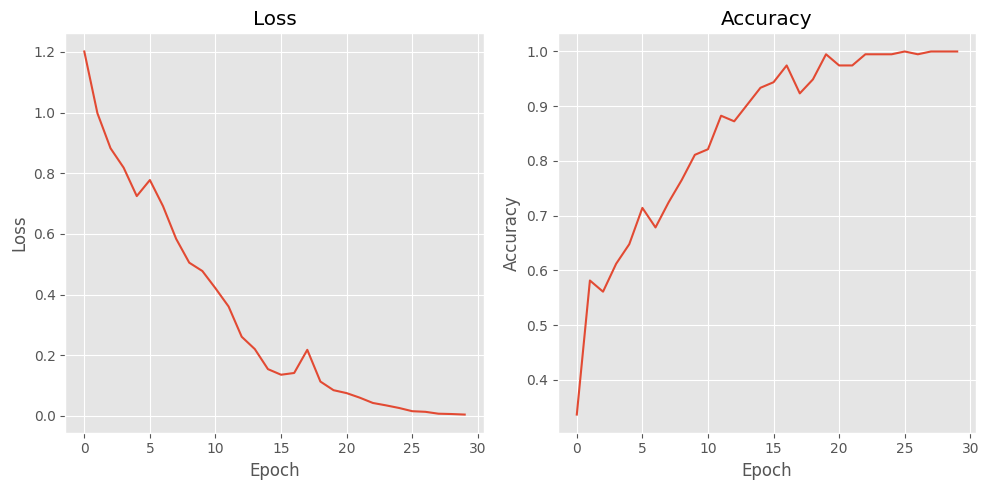

In [398]:

plt.style.use("ggplot")
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot loss
axes[0].plot(loss_list)
axes[0].set_title("Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")

# Plot accuracy
axes[1].plot(accuracy_list)
axes[1].set_title("Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


# Evaluate your CNN
In this section, you will set your model in evaluation mode and evaluate it on your test data. 
You have to implement the evaluation loop and report the test accuracy.

In [399]:

# Set the model to evaluation mode
model.eval()


test_accuracy = 0
# Evaluation loop
with torch.no_grad():
    # ================= Your Code Here ===============
    for data in test_dataloader:
        inputs, labels, _ = data

        # Move inputs and labels to the correct device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Get predictions
        _, predicted = torch.max(outputs.data, 1)
        
        # Update correct and total counts
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

# Calculate the accuracy
test_accuracy = correct_predictions / total_predictions

    # ================================================


    
print(f"Test Accuracy: {test_accuracy:.2%}")


Test Accuracy: 94.29%


[ WARN:0@8880.433] global loadsave.cpp:248 findDecoder imread_('data/images/shiinotic.png'): can't open/read file: check file path/integrity
[ WARN:0@8880.437] global loadsave.cpp:248 findDecoder imread_('data/images/torracat.png'): can't open/read file: check file path/integrity


Visualize performance on test data

[ WARN:0@8880.567] global loadsave.cpp:248 findDecoder imread_('data/images/shiinotic.png'): can't open/read file: check file path/integrity
[ WARN:0@8880.570] global loadsave.cpp:248 findDecoder imread_('data/images/torracat.png'): can't open/read file: check file path/integrity


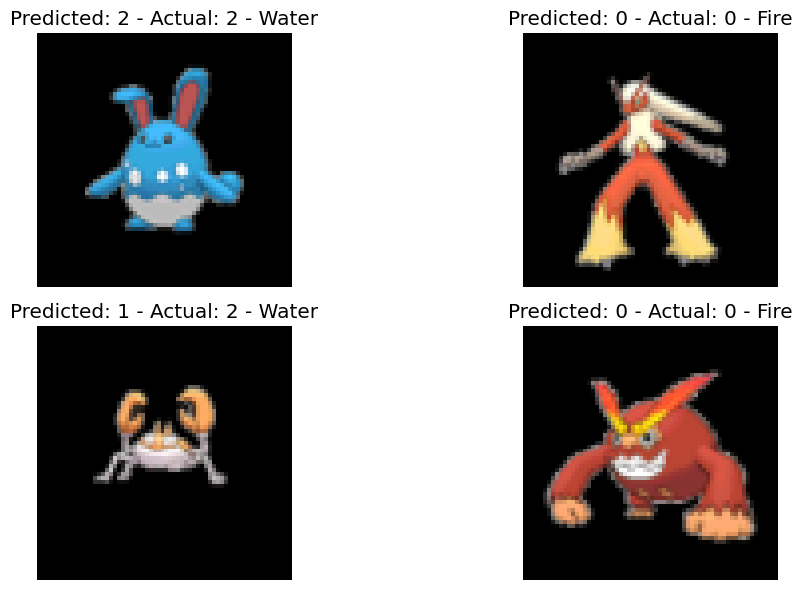

In [400]:
# Set the model to evaluation mode
model.eval()

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

# Iterate over the first 4 images in the test dataset
for i, (image, label, label_name) in enumerate(list(test_dataset)[:4]):
    # Move the image to the device
    image = image.to(device)

    # Forward pass
    output = model(image.unsqueeze(0))

    # Calculate the predicted label
    _, predicted_label = torch.max(output, 1)

    # Convert the image tensor to numpy array
    image = image.permute(1, 2, 0).cpu().numpy()

    # Multiply image by std and add mean
    image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    image *= 255
    image = image.astype(np.uint8)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # Plot the image and predicted label
    ax = axes[i // 2, i % 2]
    ax.imshow(image)
    ax.set_title(f"Predicted: {predicted_label.item()} - Actual: {label} - {label_name}")
    ax.axis("off")

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()